# Dealing with limited data for semantic segmentation
> Strategies for efficiently collecting more data to target specific areas of underperforming models and techniques to adopt to maximize utility of the data



After we have evaluated how well a model has performed, we do one of two things:

1. decide we are happy with how the model has performed on the validation set, and report the model performance on the test set (and validation set). Hooray!
2. Diagnose issues with our model in terms of false positives or false negatives and make a plan for improving performance on classes that are underperforming.

One of the most fundamental and high impact practices to improve model performance, particularly with deep learning, is to increase the overall size of the training dataset, focusing on classes that are underperforming. However, in remote sensing it is difficult and time consuming to acquire high quality training data labels, particularly compared to other domains where computer vision and machine learning techniques are used. 

Because of this unique difficulty when annotating geospatial imagery, we need to do two things:
1. closely inspect our original labeled dataset for quality issues, such as mismatch with the imagery due to date, incorrect class labels, and incorrect label boundaries
2. weigh the cost and benefits of annotating new labels or try other approaches to maximize our model's performance with the data we already have.

Part 1 of this Lesson will describe considerations for setting up an annotation campaign, keeping in mind data quality issues that have come up during the RAMI and Terrabio projects.

Part 2 will cover techniques for maximizing the performance of models trained with limited data, assuming label quality is sufficient.

## Specific concepts that will be covered

Part 1:
* How to decide on a class hierarchy prior to an annotation campaign and what inputs should be made available to an annotator
* How to efficiently annotate geospatial imagery for semantic segmentation (pixel-wise classification)
* When it makes sense to annotate for instance segmentation (predictions are vectors) instead of semantic segmentation (predictions are rasters)
* Choosing a sampling strategy that represents classes of interest

Part 2:
* Transfer Learning from pretrained models.  We'll use a COCO model as an example.
* Data augmentation, or multiplying your training data with image transforms

**Audience:** This post is geared towards intermediate users who are comfortable with basic machine learning concepts. 

**Time Estimated**: 60-120 min

## Part 2: Limited Data Techniques

In [8]:
# install required libraries
!pip install -q rasterio==1.2.10
!pip install -q geopandas==0.10.2
!pip install -q git+https://github.com/tensorflow/examples.git
!pip install -q -U tfds-nightly
!pip install -q focal-loss
!pip install -q tensorflow-addons==0.8.3
#!pip install -q matplotlib==3.5 # UNCOMMENT if running on LOCAL
!pip install -q scikit-learn==1.0.1
!pip install -q scikit-image==0.18.3
!pip install -q tf-explain==0.3.1
!pip install -q segmentation_models
!pip install -q albumentations

You should consider upgrading via the '/home/rave/miniconda3/envs/servir/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/rave/miniconda3/envs/servir/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/rave/miniconda3/envs/servir/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/rave/miniconda3/envs/servir/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/rave/miniconda3/envs/servir/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/rave/miniconda3/envs/servir/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/rave/miniconda3/envs/servir/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/rave/miniconda3/envs/servir/bin/python -m pip install --upgrade pip' command.
You should consi

In [1]:
# import required libraries
import os, glob, functools, fnmatch, io, shutil
from zipfile import ZipFile
from itertools import product

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image

import rasterio
from rasterio import features, mask

import geopandas as gpd
import pandas as pd

import tensorflow as tf
from tensorflow.python.keras import layers, losses, models
from tensorflow.python.keras import backend as K  
import tensorflow_addons as tfa
from keras.utils.vis_utils import plot_model

from tensorflow_examples.models.pix2pix import pix2pix
from focal_loss import SparseCategoricalFocalLoss
from tf_explain.callbacks.activations_visualization import ActivationsVisualizationCallback

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
from time import sleep
from tqdm.notebook import tqdm
import datetime
import skimage.io as skio

import segmentation_models as sm
from segmentation_models.losses import bce_jaccard_loss

from albumentations import (
    Compose, RandomBrightness, JpegCompression, HueSaturationValue, RandomContrast, HorizontalFlip,
    Rotate
)

# set your root directory and tiled data folders
if 'google.colab' in str(get_ipython()):
    # this is a google colab specific command to ensure TF version 2 is used. 
    # it won't work in a regular jupyter notebook, for a regular notebook make sure you install TF version 2
    %tensorflow_version 2.x
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    root_dir = '/content/gdrive/My Drive/servir-tf-devseed/' 
    workshop_dir = '/content/gdrive/My Drive/servir-tf-devseed-workshop'
    print('Running on Colab')
else:
    root_dir = os.path.abspath("./data/servir-tf-devseed")
    workshop_dir = os.path.abspath('./servir-tf-devseed-workshop')
    print(f'Not running on Colab, data needs to be downloaded locally at {os.path.abspath(root_dir)}')

img_dir = os.path.join(root_dir,'indices/') # or os.path.join(root_dir,'images_bright/') if using the optical tiles
label_dir = os.path.join(root_dir,'labels/')

Segmentation Models: using `keras` framework.
Not running on Colab, data needs to be downloaded locally at /home/rave/servir-amazonia-ml/ds_book/docs/data/servir-tf-devseed


In [2]:
# go to root directory
%cd $root_dir 

/home/rave/servir-amazonia-ml/ds_book/docs/data/servir-tf-devseed


### Enabling GPU

This notebook can utilize a GPU and works better if you use one. Hopefully this notebook is using a GPU, and we can check with the following code.

If it's not using a GPU you can change your session/notebook to use a GPU. See [Instructions](https://colab.research.google.com/notebooks/gpu.ipynb#scrollTo=sXnDmXR7RDr2)

In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


### Check out the labels

In [4]:
# Read the classes
class_index = pd.read_csv(os.path.join(root_dir,'terrabio_classes.csv'))
class_names = class_index.class_name.unique()
print(class_index) 

   class_id   class_name
0         0   Background
1         1     Bushland
2         2      Pasture
3         3        Roads
4         4        Cocoa
5         5   Tree cover
6         6    Developed
7         7        Water
8         8  Agriculture


In [5]:
train_df = pd.read_csv(os.path.join(workshop_dir, "train_file_paths.csv"))
validate_df =  pd.read_csv(os.path.join(workshop_dir, "validate_file_paths.csv"))
test_df =  pd.read_csv(os.path.join(workshop_dir, "test_file_paths.csv"))

In [6]:
x_train_filenames = train_df["img_names"]
y_train_filenames = train_df["label_names"]
x_val_filenames = train_df["img_names"]
y_val_filenames = train_df["label_names"]
x_test_filenames = train_df["img_names"]
y_test_filenames = train_df["label_names"]

num_train_examples = len(x_train_filenames)
num_val_examples = len(x_val_filenames)
num_test_examples = len(x_test_filenames)

### Augmentation and Display Functions

In [7]:
# set input image shape
img_shape = (224, 224, 3)
# set batch size for model
batch_size = 8

# load your data
# Function for reading the tiles into TensorFlow tensors 
# See TensorFlow documentation for explanation of tensor: https://www.tensorflow.org/guide/tensor
def _process_pathnames(fname, label_path):
  # We map this function onto each pathname pair  
  img_str = tf.io.read_file(fname)
  img = tf.image.decode_png(img_str, channels=3)

  label_img_str = tf.io.read_file(label_path)

  # These are png images so they return as (num_frames, h, w, c)
  label_img = tf.image.decode_png(label_img_str, channels=1)
  # The label image should have any values between 0 and 8, indicating pixel wise
  # foreground class or background (0). We take the first channel only. 
  label_img = label_img[:, :, 0]
  label_img = tf.expand_dims(label_img, axis=-1)
  return img, label_img

# Function to augment the data with horizontal flip
def flip_img_h(horizontal_flip, tr_img, label_img):
  if horizontal_flip:
    flip_prob = tf.random.uniform([], 0.0, 1.0)
    tr_img, label_img = tf.cond(tf.less(flip_prob, 0.5),
                                lambda: (tf.image.flip_left_right(tr_img), tf.image.flip_left_right(label_img)),
                                lambda: (tr_img, label_img))
  return tr_img, label_img

# Function to augment the data with vertical flip
def flip_img_v(vertical_flip, tr_img, label_img):
  if vertical_flip:
    flip_prob = tf.random.uniform([], 0.0, 1.0)
    tr_img, label_img = tf.cond(tf.less(flip_prob, 0.5),
                                lambda: (tf.image.flip_up_down(tr_img), tf.image.flip_up_down(label_img)),
                                lambda: (tr_img, label_img))
  return tr_img, label_img

# Function to augment the images and labels
def _augment(img,
             label_img,
             resize=None,  # Resize the image to some size e.g. [256, 256]
             #scale=1,  # Scale image e.g. 1 / 255.
             horizontal_flip=False,
             vertical_flip=False): 
  if resize is not None:
    # Resize both images
    label_img = tf.image.resize(label_img, resize)
    img = tf.image.resize(img, resize)
  
  img, label_img = flip_img_h(horizontal_flip, img, label_img)
  img, label_img = flip_img_v(vertical_flip, img, label_img)
  img = tf.cast(img, tf.float32) # * scale  #tf.to_float(img) * scale 
  #label_img = tf.cast(label_img, tf.float32) * scale
  #print("tensor: ", tf.unique(tf.keras.backend.print_tensor(label_img)))
  return img, label_img

# Main function to tie all of the above four dataset processing functions together 
def get_baseline_dataset(filenames, 
                         labels,
                         preproc_fn=functools.partial(_augment),
                         threads=5, 
                         batch_size=batch_size,
                         shuffle=True):           
  num_x = len(filenames)
  # Create a dataset from the filenames and labels
  dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
  # Map our preprocessing function to every element in our dataset, taking
  # advantage of multithreading
  dataset = dataset.map(_process_pathnames, num_parallel_calls=threads)
  if preproc_fn.keywords is not None and 'resize' not in preproc_fn.keywords:
    assert batch_size == 1, "Batching images must be of the same size"

  dataset = dataset.map(preproc_fn, num_parallel_calls=threads)
  
  if shuffle:
    dataset = dataset.shuffle(num_x)
  
  
  # It's necessary to repeat our data for all epochs 
  dataset = dataset.repeat().batch(batch_size)
  return dataset

In [8]:
# dataset configuration for training
tr_cfg = {
    'resize': [img_shape[0], img_shape[1]],
    #'scale': 1 / 255.,
    'horizontal_flip': True,
    'vertical_flip': True,
}
tr_preprocessing_fn = functools.partial(_augment, **tr_cfg)
train_ds = get_baseline_dataset(x_train_filenames,
                                y_train_filenames,
                                preproc_fn=tr_preprocessing_fn,
                                batch_size=batch_size)

# dataset configuration for validation
val_cfg = {
    'resize': [img_shape[0], img_shape[1]],
    #'scale': 1 / 255.,
}
val_preprocessing_fn = functools.partial(_augment, **val_cfg)
val_ds = get_baseline_dataset(x_val_filenames,
                              y_val_filenames, 
                              preproc_fn=val_preprocessing_fn,
                              batch_size=batch_size)

Display functions for monitoring model progress and visualizing arrays

In [9]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

def show_predictions(image=None, mask=None, dataset=None, num=1):
  if image is None and dataset is None:
    # this is just for showing keras callback output. in practice this should be broken out into a different function
    sample_image = skio.imread(f'{img_dir}/tile_terrabio_15684.png')
    sample_mask = skio.imread(f'{label_dir}/tile_terrabio_15684.png')
    mp = create_mask(model.predict(sample_image[tf.newaxis, ...]))
    mpe = tf.keras.backend.eval(mp)
    display([sample_image, sample_mask[..., tf.newaxis], mpe])
  elif dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    mp = create_mask(model.predict(image[tf.newaxis, ...]))
    mpe = tf.keras.backend.eval(mp)
    display([image, mask, mpe])

class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

callbacks = [
    DisplayCallback()
]

In [10]:
# define model

sm.set_framework('tf.keras')

sm.framework()

model = sm.Unet('resnet34', activation='softmax', classes = 9, encoder_weights='imagenet')

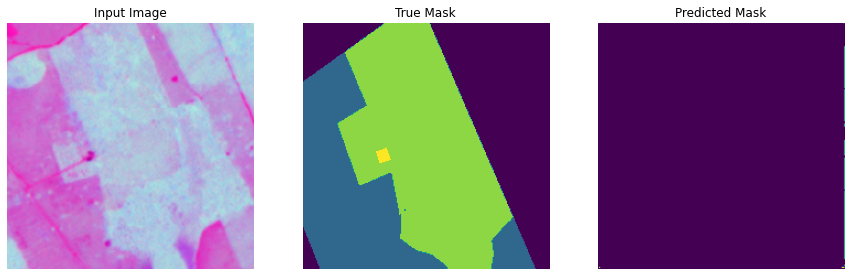


Sample Prediction after epoch 4

395/395 [==============================] - 40s 101ms/step - loss: 1.2951 - accuracy: 0.9523 - iou_score: 0.0365 - val_loss: 1.2539 - val_accuracy: 0.9515 - val_iou_score: 0.0347


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss=SparseCategoricalFocalLoss(gamma=2, from_logits=True), #tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy', sm.metrics.iou_score])

EPOCHS=4
model_history = model.fit(
   train_ds,
   epochs=EPOCHS,
   steps_per_epoch=int(np.ceil(num_train_examples / float(batch_size))),
   validation_data=val_ds,
   validation_steps=int(np.ceil(num_val_examples / float(batch_size))),
   callbacks=callbacks
)

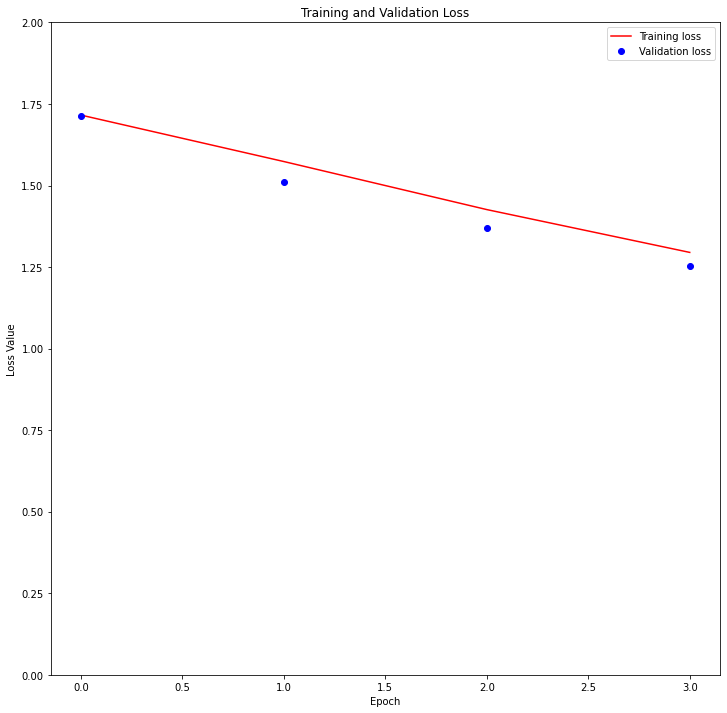

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 2])
plt.legend()
plt.show()

## Data Augmentation with Albumentations